# BÀI TẬP 2
>(c) Huynh Ngoc Thuat, 19TCLC_DT2

## 1.Phát biểu bài toán

Dataset chứa tất cả các giao dịch xảy ra trong khoảng thời gian từ 1/12/2009 -> 9/12/2011 ở một hệ thống bán lẻ trực tuyến không có cửa hàng có trụ sở tại Anh. Đối với những người làm dịch vụ thì khai thác thông tin khách hàng của mình là một việc hết sức cần thiết, từ đó ta có thể phân khúc các khách hàng của ta và tìm ra khánh hàng tiềm năng nhất. Từ đó đưa ra những chính sách chăm sóc khánh hàng phù hợp.

- Mục tiêu của bài toán: Phân khúc được khánh hàng qua 3 yếu tố: Lần mua hàng gần nhất(Nearest Purchase), Tần suất mua hàng(Frequency), Tổng số tiền đã mua(Total Purchased).
- Thuật toán sử dụng: Kmeans clustering, Hierarchical clustering

## 2.Các bước triển khai

#### a. Import required Python packages.

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import scipy.stats as stat
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

#### b. Read data from file csv 

In [4]:
data = pd.read_csv('E:\online_retail_II.csv')
data.info()
data.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\online_retail_II.csv'

#### c. Xử lý dữ liệu

In [ ]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [ ]:
# Loại bỏ các dữ liệu trống
data = data[data['Customer ID'].notna()]

# Chuyển InvoiceDate về định dạng date time
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']) 
data['InvoiceDate'].describe()

# Diff: thời gian hoá đơn cuối cùng - thời gian của mỗi hoá đơn
max_date = max(data['InvoiceDate'])
data['Diff'] = max_date - data['InvoiceDate']
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,697 days 08:53:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,697 days 08:53:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00


c1. Tìm ra số ngày mua hàng gần nhất của mỗi khách hàng

In [ ]:
# Gộp ID khách hàng mà tìm min của Diff
nearest_purchase = data.groupby('Customer ID')['Diff'].min()
nearest_purchase = nearest_purchase.reset_index()
nearest_purchase['Diff'] = nearest_purchase['Diff'].dt.days
nearest_purchase.columns = ['Customer ID', 'Nearest Purchase']
nearest_purchase.head()

,Customer ID,Nearest Purchase
0,12346.0,326
1,12347.0,40
2,12348.0,76
3,12349.0,19
4,12350.0,311


c2. Tính tổng số tiền mua mỗi khách hàng đã chi tiêu tại hệ thống

In [ ]:
# Tổng tiền mỗi hoá đƠn = số lượng * đơn giá
data['Amount'] = data['Quantity'] * data['Price']
total_purchased = data.groupby('Customer ID')['Amount'].sum() # Tổng các đơn hàng của mỗi khách hàng
total_purchased = total_purchased.reset_index()
total_purchased.columns = ['Customer ID', 'Total Purchased']
total_purchased.head()

,Customer ID,Total Purchased
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


c3. Số lần mua hàng của mỗi khách hàng

In [ ]:
frequency = data.groupby('Customer ID')['Invoice'].count()
frequency = frequency.reset_index()
frequency.columns = ['Customer ID', 'Frequency']
frequency.head()

,Customer ID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


c4. Gộp 3 thuộc tính lại 1 data frame

In [ ]:
NP_TP = pd.merge(nearest_purchase, total_purchased, on='Customer ID', how='inner')
result = pd.merge(NP_TP, frequency, on='Customer ID', how='inner')
result.head()

,Customer ID,Nearest Purchase,Total Purchased,Frequency
0,12346.0,326,0.00,2
1,12347.0,40,4310.00,182
2,12348.0,76,1797.24,31
3,12349.0,19,1757.55,73
4,12350.0,311,334.40,17


In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer ID       4372 non-null   float64
 1   Nearest Purchase  4372 non-null   int64  
 2   Total Purchased   4372 non-null   float64
 3   Frequency         4372 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 170.8 KB


c5. Xử lý ngoại lệ

Text(0.5, 0, 'Attributes')

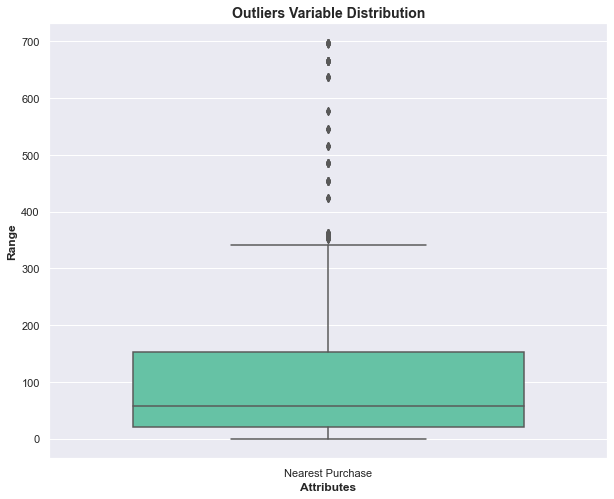

In [ ]:
attributes = ['Nearest Purchase']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = result[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Text(0.5, 0, 'Attributes')

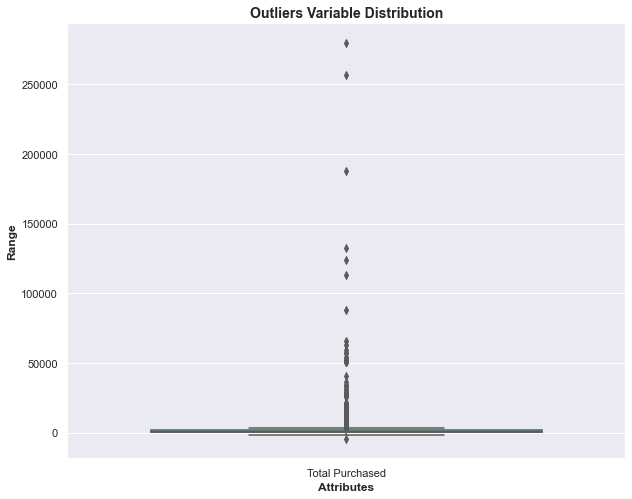

In [ ]:
attributes = ['Total Purchased']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = result[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Hàm xử lý ngoại lệ
def outliers(data):
    # Xoá các giá trị ngoại lệ của Nearest Purchase
    Q3 , Q1 = np.percentile(data['Nearest Purchase'], [95, 5])
    IQR = Q3 - Q1
    upper_bridge = Q3 + 1.5 * IQR
    lower_bridge = Q1 + 1.5 * IQR
    print(upper_bridge, " ", lower_bridge)
    data.loc[data['Nearest Purchase'] >= upper_bridge, 'Nearest Purchase'] = round(upper_bridge)
    # data.loc[data['Nearest Purchase'] <= lower_bridge, 'Nearest Purchase'] = round(lower_bridge)

    # Xoá các giá trị ngoại lệ của Total Purchase
    Q3 , Q1 = np.percentile(data['Total Purchased'], [95, 5])
    IQR = Q3 - Q1
    upper_bridge = Q3 + 1.5 * IQR
    lower_bridge = Q1 + 1.5 * IQR
    data.loc[data['Total Purchased'] >= upper_bridge, 'Total Purchased'] = round(upper_bridge)
    # data.loc[data['Total Purchased'] <= lower_bridge, 'Total Purchased'] = round(lower_bridge)

    # Xoá các giá trị ngoại lệ của Frequency
    upper_boundary = data['Frequency'].mean() + 1.5 * data['Frequency'].std()
    lower_boundary=data['Frequency'].mean() - 1.5 * data['Frequency'].std()
    data.loc[data['Frequency'] >= round(upper_boundary), 'Frequency'] = round(upper_boundary)
    data.loc[data['Frequency'] <= round(lower_boundary), 'Frequency'] = round(lower_boundary)

    return data

result_outliers = outliers(result)
result_outliers.info()

780.5   469.5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer ID       4372 non-null   float64
 1   Nearest Purchase  4372 non-null   int64  
 2   Total Purchased   4372 non-null   float64
 3   Frequency         4372 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 170.8 KB


c6. Chuẩn hoá dữ liệu để giảm bớt sự ảnh hưởng của dữ liệu lớn

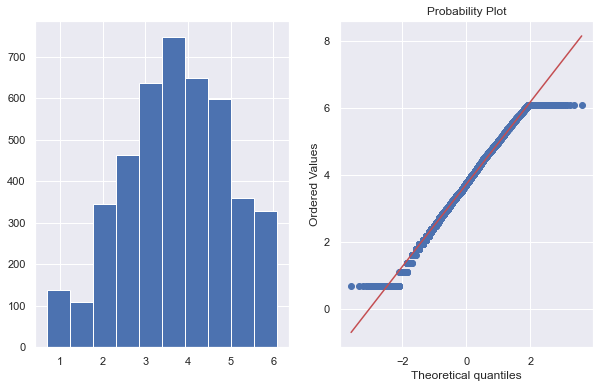

In [ ]:
# Trước khi chuẩn hoá thì biến đổi dữ liệu về phân bố chuẩn
result_standard = result_outliers[['Customer ID', 'Nearest Purchase', 'Total Purchased', 'Frequency']]
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist() # histogram
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=plt)# prob plot
    plt.show()

# Lấy LOGARIT
result_standard['Nearest Purchase']=np.log1p(result_standard['Nearest Purchase'])
result_standard['Frequency']=np.log1p(result_standard['Frequency'])
# plot_data(result_outliers, 'Nearest Purchase')
# plot_data(result_outliers, 'Total Purchased')
plot_data(result_standard, 'Frequency') # Cột Frequency không cần biến đổi


Dùng hàm fit_transform() của lớp MinMaxScaler của thư viện sklearn.preprocessing để chuẩn hoá dữ liệu về dãy [0;1]

In [ ]:
result_transform = result_standard[['Nearest Purchase', 'Total Purchased', 'Frequency']]
min_max = MinMaxScaler()
df_converted = result_transform[['Nearest Purchase', 'Total Purchased', 'Frequency']]
result_minmax = pd.DataFrame(min_max.fit_transform(df_converted), columns=df_converted.columns)

result_minmax.head()


,Nearest Purchase,Total Purchased,Frequency
0,0.884204,0.235602,0.075080
1,0.567112,0.472433,0.836294
2,0.663357,0.334359,0.513402
3,0.457488,0.332178,0.668636
4,0.877033,0.253977,0.406862


#### d. Chọn số cụm thích hợp - Phương pháp elbow method
- Chúng ta sẽ sử dụng thuộc tính tích hợp trong sklearn 'inertia_'
- 'inertia_' - Tổng bình phương khoảng cách đến mỗi tâm
- total_distance - Phụ thuộc vào K, vớI K = 1, total_distance là lớn nhất

In [ ]:
total_distance_arr = []
for i in range(1,10):
    kmns = KMeans(i)
    kmns.fit(result_minmax)
    total_distance = kmns.inertia_
    total_distance_arr.append(total_distance)
    

Hàm biến dạng dựa trên số cụm và tổng khoảng cách từ mỗi điểm tới tâm

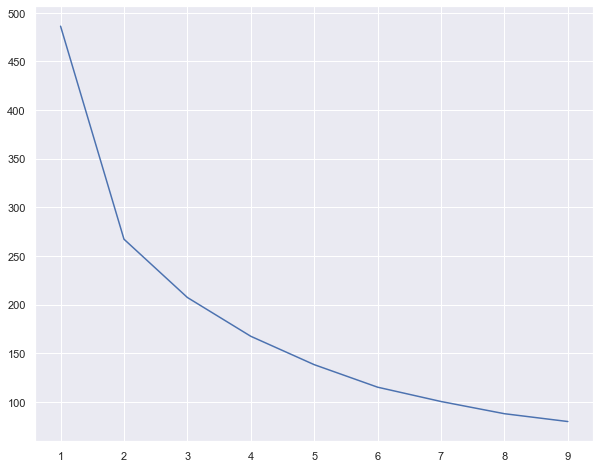

In [ ]:
plt.plot(range(1,10), total_distance_arr)

Ở đây chúng ta sẽ chọn số cụm bằng 4 vì khi số cụm lớn hơn 4 thì tốc độ suy giảm của hàm biến dạng nhỏ hơn nhiều so với trước đó, và lớn hơn 4 thì tốc độ suy giảm của hàng biến dạng không thay đổi nhiều.
- Số cụm Kmeans: 4

#### e. Tiến hành phân cụm

In [ ]:
# Hàm phân cụm
def kmeans_clusters_func(data, num_clusters): 
    kmeans = KMeans(num_clusters)
    kmeans.fit(data)

    clusters = kmeans.predict(data)
    result_minmax['Clusters'] = clusters

    return result_minmax, clusters

# Số cụm là 4
result_minmax, clusters = kmeans_clusters_func(result_minmax, 4)
result_outliers.head()

,Customer ID,Nearest Purchase,Total Purchased,Frequency
0,12346.0,326,0.00,2
1,12347.0,40,4310.00,182
2,12348.0,76,1797.24,31
3,12349.0,19,1757.55,73
4,12350.0,311,334.40,17


e1. Khởi tạo hàm vẽ đồ thị dưới dạng 2D và 3D

In [ ]:
def plot_kmeans_3D(data, title):
    fig = plt.figure(figsize=(20, 8), dpi=100)
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data['Nearest Purchase'], 
                data['Total Purchased'], 
                data['Frequency'],
                c = data['Clusters'], 
                cmap ='rainbow')

    ax.set_xlabel('Nearest Purchase')
    ax.set_ylabel('Total Purchase')
    ax.set_zlabel('Frequency')
    ax.set_title(title)

def plot_kmeans_2D(X, labels):
    # Chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int)])

    # Thêm nhãn cho mỗi cụm
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('T-SNE visualization')


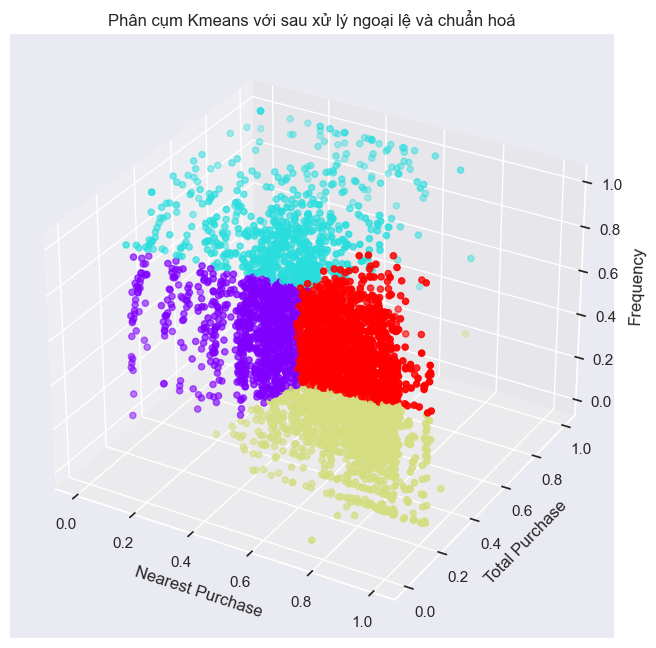

In [ ]:
plot_kmeans_3D(result_minmax, "Phân cụm Kmeans với sau xử lý ngoại lệ và chuẩn hoá")

- Thuật toán đã chia ra cho chúng ta 4 cụm tách biệt nhau, nếu muốn quan sát rõ ràng các cụm hơn thì chúng ta nên đưa chúng về đồ thị 2D
- Ở đây chúng ta sẽ ứng dụng thuật toán t-SNE(t-Distributed Stochastic Neighbor Embedding: một phương pháp khác để biểu diễn PCA) là một kỹ thuật giảm kích thước để trực quan hoá dữ liệu giúp biểu diễn một tập hợp các điểm trong không gian chiều cao trong không gian hai hoặc ba chiều.
- Để huấn luyện mô hình t-SNE trên sklearn chúng ta sử dụng class TSNE. Chúng ta cần khai báo số lượng chiều dữ liệu sau khi giảm thông qua đối số n_components.
- Lưu ý nhỏ: Thuật toán này là một trong những phương pháp tính toán tốn kém nhất và khi sử dụng nên sử dụng các kỹ thuật khác như missing value ratio...

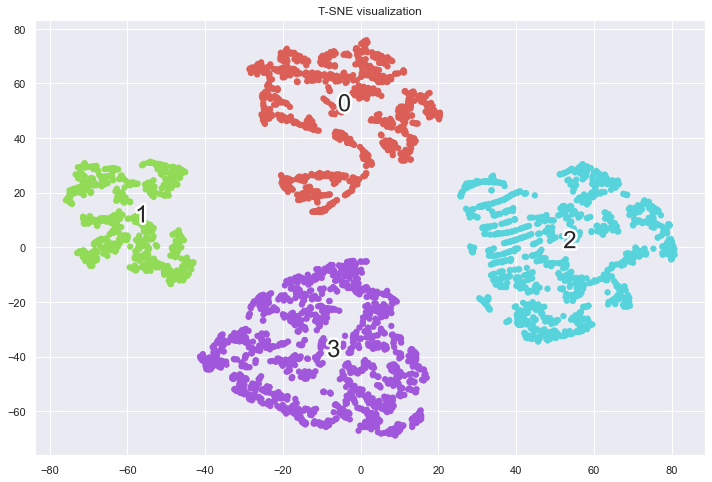

In [ ]:
X_tsne = TSNE(n_components=2, random_state=123).fit_transform(result_minmax)
plot_kmeans_2D(X_tsne, clusters)

e2. Tiến hành tính giá trị trung bình của mỗi cụm và đưa ra nhận xét

In [ ]:
result_outliers = outliers(result)
result_outliers['Clusters'] = clusters
result_outliers.groupby('Clusters').agg(
    {
        'Nearest Purchase' : 'mean',
        'Total Purchased' : 'mean',
        'Frequency' : 'mean'
    }
).round(2)

780.5   469.5


,Nearest Purchase,Total Purchased,Frequency
Clusters,,,
0,17.44,1012.23,60.09
1,18.51,5156.54,198.20
2,178.70,324.17,11.07
3,131.42,1024.49,68.72


- Có thể thấy là cụm số 1 có thời gian mua hàng gần nhất, tổng số tiền mua hàng và tần xuất mua nhiều nhất -> Có thể đánh giá đây là nhóm khách hàng tiềm năng của mình. Từ đây ta có thể đưa ra các chính sách ưu đãi hơn với nhóm khách hàng này. Ví dụ: khuyến mãi, tri ân cuối năm, ...

Tập khách hàng tiềm năng của mình

In [ ]:
potential_customers = result_outliers[result_outliers['Clusters'] == 1]
potential_customers.head()

,Customer ID,Nearest Purchase,Total Purchased,Frequency,Clusters
1,12347.0,40,4310.00,182,1
12,12359.0,9,6245.53,230,1
15,12362.0,12,5154.58,230,1
20,12370.0,52,3545.69,167,1
39,12395.0,5,2998.28,159,1


# Phân cụm sử dụng thuật toán Hierarchical Clustering(Phân cụm thứ cấp)
Sử dụng thư viện hierarchy của scipy

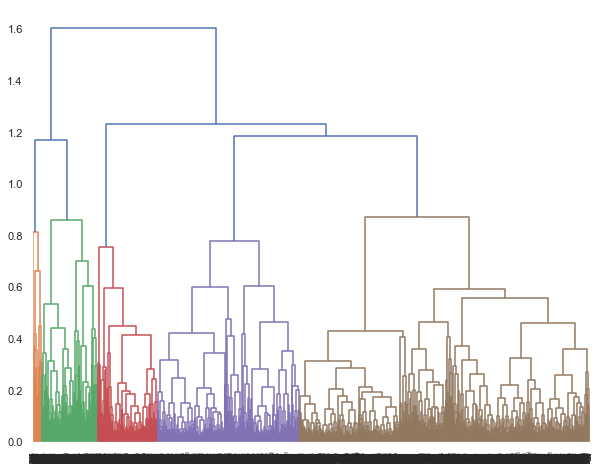

In [ ]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Khoảng cách giữa các cụm(Khoảng cách euclidean): 
# complete : max(Đang sử dụng)
# single : min
# average
# centroid
data_hierarchical  = result_minmax[['Nearest Purchase', 'Total Purchased', 'Frequency']]
mergings = linkage(data_hierarchical, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Cắt thành các cụm nhỏ

In [ ]:
# Chia các cụm với số cụm là 4
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, ..., 0, 3, 2])

Tính giá trị trung bình của các cụm và so sánh với thuật toán Kmeans

In [ ]:
result_hierarchical = outliers(result)
result_hierarchical['Clusters'] = cluster_labels
print("Số khách hàng tiềm năng sử dụng phân cụm Hierarchical:", result_hierarchical[result_hierarchical['Clusters'] == 3].shape[0])
result_hierarchical.groupby('Clusters').agg(
    {
        'Nearest Purchase' : 'mean',
        'Total Purchased' : 'mean',
        'Frequency' : 'mean'
    }
).round(2)


780.5   469.5
Số khách hàng tiềm năng sử dụng phân cụm Hierarchical: 517


,Nearest Purchase,Total Purchased,Frequency
Clusters,,,
0,139.45,342.02,10.69
1,120.39,1193.84,75.73
2,12.98,754.81,36.88
3,11.51,5712.84,155.28


In [ ]:
result_outliers = outliers(result)
result_outliers['Clusters'] = clusters
print("Số khách hàng tiềm năng sử dụng phân cụm Kmeans:", result_outliers[result_outliers['Clusters'] == 1].shape[0])
result_outliers.groupby('Clusters').agg(
    {
        'Nearest Purchase' : 'mean',
        'Total Purchased' : 'mean',
        'Frequency' : 'mean'
    }
).round(2)

780.5   469.5
Số khách hàng tiềm năng sử dụng phân cụm Kmeans: 685


,Nearest Purchase,Total Purchased,Frequency
Clusters,,,
0,17.44,1012.23,59.79
1,18.51,5156.54,146.23
2,178.70,324.17,11.07
3,131.42,1024.49,66.02


### Nhận xét:
- Đối với bộ dữ liệu này sau khi phân cụm Hierarchical cho ra kết quả mong muốn tốt hơn phân cụm Kmeans
- Chắt lọc được tối ưu danh sách khánh hàng tiềm năng của mình

# Có thử thêm thuật toán DBSCAN nhưng thấy không phù hợp với dữ liệu đang có

In [ ]:
# data_DBSCAN = result[['Nearest Purchase', 'Total Purchased', 'Frequency']]
# data_DBSCAN.head()

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler_data = scaler.fit_transform(data_DBSCAN)
# scaler_data

In [ ]:
# from sklearn.cluster import DBSCAN
# number_of_outliers  = []
# percentage_of_outliers = []

# min_samples = 2*scaler_data.shape[1]

# for eps in np.linspace(0.001, 3, 50):
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     dbscan.fit(scaler_data)

#     number_of_outliers.append(np.sum(dbscan.labels_==-1))

#     perc_outliers = 100*np.sum(dbscan.labels_==-1)/len(dbscan.labels_)
#     percentage_of_outliers.append(perc_outliers)

In [ ]:
# dbscan = DBSCAN(eps=2, min_samples=6)
# dbscan.fit(scaler_data)
# dbscan.labels_